# Object Detection with YOLO

YOLO = You Only Look Once

## Contents
0. Introduction to YOLO
1. YOLO v3 (outdated)
2. YOLO v5
3. YOLO v8

## 0. Introduction to YOLO

Here are some links on YOLO:

#### The AI Guy on YOLO
https://github.com/theAIGuysCode/YOLOv3-Cloud-Tutorial

See also this notebook on YOLOV3: https://colab.research.google.com/drive/1a9a42ps597AiEWwUyXa-nHVkONUZ6FX9#scrollTo=3DWRrVatZZZg

#### Others on YOLO

And another github on YOLO: https://github.com/arshren/YOLOV3

And another on YOLO: https://github.com/karolmajek/darknet-pjreddie

And somebody made a Python wrapper for YOLO: https://github.com/goktug97/pyyolo

And another tutorial: https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html

In [ ]:
#Introduction of YOLO by Joe Redmond in 2017
from IPython.lib.display import YouTubeVideo
YouTubeVideo('Cgxsv1riJhI')

## 1. Yolo v3 (outdated)

source: #Source: https://github.com/arshren/YOLOV3

In [ ]:
#Get the dependencies
import wget
wget.download("https://pjreddie.com/media/files/yolov3.weights")

In [ ]:
import wget
zebra = wget.download('https://upload.wikimedia.org/wikipedia/commons/c/c9/Zebra_Zuid-Afrika.jpg')

import IPython
IPython.display.Image(zebra) 

In [ ]:
!pip show tensorflow
print("------------------------")
!pip show keras
print("------------------------")
!pip show pandas

In [ ]:
import keras
keras.__version__

In [ ]:
!pip install keras

In [ ]:
# YOLO v3
import os

import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
import keras
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.models import load_model, Model
#from keras.layers.merge import add, concatenate
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle

%matplotlib inline

In [ ]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

In [ ]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [ ]:
# creating the YOLO model
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

In [ ]:
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# make the yolov3 model to predict 80 classes on COCO

yolov3 = make_yolov3_model()

# load the weights trained on COCO into the model
weight_reader = WeightReader('yolov3.weights') # To do
weight_reader.load_weights(yolov3)

In [ ]:
# save the model to file
yolov3.save('yolov3.h5')

In [ ]:
# load yolov3 model
yolov3 = load_model('yolov3.h5')

In [ ]:
from numpy import expand_dims
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [ ]:
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = zebra #upload photo TO DO
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))


In [ ]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [ ]:
#decode_netout() that will take each one of the NumPy arrays, one at a time, 
#and decode the candidate bounding boxes and class predictions
def decode_netout(netout, anchors, obj_thresh,  net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

In [ ]:
# bounding boxes will be stretched back into the shape of the original image
#will allow plotting the original image and draw the bounding boxes, hopefully detecting real objects.
# correct the sizes of the bounding boxes for the shape of the image
#correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
# suppress non-maximal boxes
#do_nms(boxes, 0.5)

In [ ]:
from matplotlib.patches import Rectangle
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='red')
    # show the plot
    plt.show()

In [ ]:
# get all of the results above a threshold
# takes the list of boxes, known labels, 
#and our classification threshold as arguments and returns parallel lists of boxes, labels, and scores.
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

In [ ]:
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = zebra
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (net_w, net_w))


# make prediction
yolos = yolov3.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yolos])

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()

for i in range(len(yolos)):
        # decode the output of the network
    boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh,  net_h, net_w)

    # correct the sizes of the bounding boxes
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

# suppress non-maximal boxes
do_nms(boxes, nms_thresh)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [ ]:
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [ ]:
  data = plt.imread('eagle.png')
    # plot the image
plt.imshow(data)

## 2. YOLO v5
 
source: https://www.youtube.com/watch?v=fu2tfOV9vbY

In [3]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16525, done.
remote: Total 16525 (delta 0), reused 0 (delta 0), pack-reused 16525
Receiving objects: 100% (16525/16525), 15.06 MiB | 7.37 MiB/s, done.
Resolving deltas: 100% (11359/11359), done.


In [4]:
cd yolov5

/Users/michielbontenbal/Documents/GitHub/100_notebooks_to_learn_python/yolov5


In [5]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [6]:
ls

CITATION.cff      benchmarks.py     hubconf.py        train.py
CONTRIBUTING.md   classify/         models/           tutorial.ipynb
LICENSE           data/             pyproject.toml    utils/
README.md         detect.py         requirements.txt  val.py
README.zh-CN.md   export.py         segment/


In [7]:
!python detect.py --source 0

detect: weights=yolov5s.pt, source=0, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.10.9 torch-2.0.0 CPU

100%|██████████████████████████████████████| 14.1M/14.1M [00:01<00:00, 12.1MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
2024-04-02 20:16:50.898 python[50928:6927073] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
1/1: 0...  Success (inf frames 1280x720 at 30.00 FPS)

0: 384x640 1 person, 156.4ms
0: 384x640 1 

In [11]:
!cd models && ls

__init__.py     experimental.py tf.py           yolov5m.yaml    yolov5x.yaml
__pycache__     hub             yolo.py         yolov5n.yaml
common.py       segment         yolov5l.yaml    yolov5s.yaml


In [13]:
import yolov5

In [14]:
dir(yolov5)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [15]:
pip install yolov5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 9.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.9 MB/s eta 0:00:0000:0100:01
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117032 sha256=14c14e09406487f26e7da6bdea90838324eb86427588cf1e8c0733407ec2488a
  Stored in directory: /Users/michielbontenbal/Library/Caches/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire
  Attempting uninstall: Pillow
    Found existing installation: Pillow 10.0.0
    Uninstalling Pillow-10.0.0:
      Successfully uninstalled Pillow-10.0.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.0
    Uninstalling matp

In [16]:
import yolov5

# load pretrained model
model = yolov5.load('yolov5s.pt')

# or load custom model
model = yolov5.load('train/best.pt')
  
# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

# set image
img = 'https://github.com/ultralytics/yolov5/raw/master/data/images/zidane.jpg'

# perform inference
results = model(img)

# inference with larger input size
results = model(img, size=1280)

# inference with test time augmentation
results = model(img, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# show detection bounding boxes on image
results.show()

# save results into "results/" folder
results.save(save_dir='results/')


AttributeError: module 'yolov5' has no attribute 'load'

## 3. Yolov8 comes with a python package

Yolov8 is made by a company called Ultralytics

In [1]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [2]:
#running a script from your webcam
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.predict(source=0, show = True)

2024-04-02 20:11:49.437 python[50771:6922009] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


1/1: 0... Success ✅ (inf frames of shape 1280x720 at 30.00 FPS)


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

0: 384x640 (no detections), 177.0ms
0: 384x640 1 person, 1 chair, 85.6ms
0: 384x640 1 person, 98.6ms
0: 384x640 1 person, 86.7ms
0: 384x640 1 person, 83.6ms
0: 384x640 1 person, 85.6ms
0: 384x640 1 person, 64.7ms
0: 384x640 1 person, 67.9ms
0: 384x640 1 person, 63.6ms
0: 384x640 1 person, 63.8ms
0: 384x640 1 person, 65.4ms
0: 384x640 1 person, 62.1ms
0: 384x640 1 person, 65.7ms
0: 384x640 

0: 384x640 1 person, 103.6ms
0: 384x640 1 person, 86.1ms
0: 384x640 1 person, 70.2ms
0: 384x640 1 person, 77.2ms
0: 384x640 1 person, 74.4ms
0: 384x640 1 person, 76.7ms
0: 384x640 1 person, 1 chair, 76.1ms
0: 384x640 1 person, 73.6ms
0: 384x640 1 person, 73.0ms
0: 384x640 1 person, 87.8ms
0: 384x640 1 person, 84.3ms
0: 384x640 1 person, 82.2ms
0: 384x640 1 person, 88.8ms
0: 384x640 1 person, 76.9ms
0: 384x640 1 person, 77.7ms
0: 384x640 1 person, 157.2ms
0: 384x640 1 person, 245.9ms
0: 384x640 1 person, 113.9ms
0: 384x640 1 person, 97.6ms
0: 384x640 1 person, 86.4ms
0: 384x640 1 person, 80.2ms
0: 384x640 1 person, 108.1ms
0: 384x640 1 person, 112.1ms
0: 384x640 1 person, 165.8ms
0: 384x640 1 person, 139.5ms
0: 384x640 1 person, 138.2ms
0: 384x640 1 person, 147.0ms
0: 384x640 1 person, 152.6ms
0: 384x640 1 person, 102.4ms
0: 384x640 1 person, 126.3ms
0: 384x640 1 person, 164.1ms
0: 384x640 1 person, 130.2ms
0: 384x640 1 person, 118.9ms
0: 384x640 1 person, 133.5ms
0: 384x640 1 person, 1

0: 384x640 1 person, 105.2ms
0: 384x640 1 person, 103.3ms
0: 384x640 1 person, 108.6ms
0: 384x640 1 person, 134.3ms
0: 384x640 1 person, 106.9ms
0: 384x640 1 person, 88.8ms
0: 384x640 1 person, 108.6ms
0: 384x640 1 person, 111.8ms
0: 384x640 1 person, 93.4ms
0: 384x640 1 person, 107.7ms
0: 384x640 1 person, 169.4ms
0: 384x640 1 person, 111.3ms
0: 384x640 1 person, 99.2ms
0: 384x640 1 person, 105.5ms
0: 384x640 1 person, 108.2ms
0: 384x640 1 person, 99.8ms
0: 384x640 1 person, 109.7ms
0: 384x640 1 person, 143.9ms
0: 384x640 1 person, 100.5ms
0: 384x640 1 person, 97.5ms
0: 384x640 1 person, 103.2ms
0: 384x640 1 person, 86.1ms
0: 384x640 1 person, 86.3ms
0: 384x640 1 person, 81.0ms
0: 384x640 1 person, 82.0ms
0: 384x640 1 person, 79.9ms
0: 384x640 1 person, 78.5ms
0: 384x640 1 person, 72.5ms
0: 384x640 1 person, 75.9ms
0: 384x640 1 person, 89.5ms
0: 384x640 1 person, 87.1ms
0: 384x640 1 person, 81.5ms
0: 384x640 1 person, 77.5ms
0: 384x640 1 person, 83.2ms
0: 384x640 1 person, 79.3ms
0: 3

0: 384x640 1 person, 1 chair, 134.8ms
0: 384x640 1 person, 119.0ms
0: 384x640 1 person, 127.5ms
0: 384x640 1 person, 93.3ms
0: 384x640 1 person, 97.8ms
0: 384x640 1 person, 87.7ms
0: 384x640 1 person, 94.2ms
0: 384x640 1 person, 90.3ms
0: 384x640 1 person, 93.0ms
0: 384x640 1 person, 97.8ms
0: 384x640 1 person, 96.6ms
0: 384x640 1 person, 98.2ms
0: 384x640 1 person, 87.5ms
0: 384x640 1 person, 74.2ms
0: 384x640 1 person, 80.4ms
0: 384x640 1 person, 76.2ms
0: 384x640 1 person, 75.4ms
0: 384x640 1 person, 87.2ms
0: 384x640 1 person, 74.0ms
0: 384x640 1 person, 77.5ms
0: 384x640 1 person, 79.3ms
0: 384x640 1 person, 85.0ms
0: 384x640 1 person, 85.0ms
0: 384x640 1 person, 1 chair, 84.7ms
0: 384x640 1 person, 82.7ms
0: 384x640 1 person, 79.0ms
0: 384x640 1 person, 93.4ms
0: 384x640 1 person, 74.5ms
0: 384x640 1 person, 81.7ms
0: 384x640 1 person, 80.7ms
0: 384x640 1 person, 103.7ms
0: 384x640 1 person, 108.3ms
0: 384x640 1 person, 102.5ms
0: 384x640 1 person, 104.9ms
0: 384x640 1 person, 93

0: 384x640 1 person, 91.3ms
0: 384x640 1 person, 88.8ms
0: 384x640 1 person, 110.1ms
0: 384x640 1 person, 98.6ms
0: 384x640 1 person, 97.0ms
0: 384x640 1 person, 99.4ms
0: 384x640 1 person, 95.9ms
0: 384x640 1 person, 100.5ms
0: 384x640 1 person, 109.4ms
0: 384x640 1 person, 104.8ms
0: 384x640 1 person, 92.1ms
0: 384x640 1 person, 90.7ms
0: 384x640 1 person, 96.9ms
0: 384x640 1 person, 103.5ms
0: 384x640 1 person, 93.3ms
0: 384x640 1 person, 111.0ms
0: 384x640 1 person, 97.7ms
0: 384x640 1 person, 112.4ms
0: 384x640 1 person, 95.8ms
0: 384x640 1 person, 105.3ms
0: 384x640 1 person, 94.5ms
0: 384x640 1 person, 83.0ms
0: 384x640 1 person, 97.6ms
0: 384x640 1 person, 89.6ms
0: 384x640 1 person, 1 chair, 92.5ms
0: 384x640 1 person, 88.4ms
0: 384x640 1 person, 91.2ms
0: 384x640 1 person, 87.2ms
0: 384x640 1 person, 80.2ms
0: 384x640 1 person, 94.6ms
0: 384x640 1 person, 95.4ms
0: 384x640 1 person, 1 chair, 99.7ms
0: 384x640 1 person, 86.4ms
0: 384x640 1 person, 96.7ms
0: 384x640 1 person, 9

0: 384x640 2 persons, 88.2ms
0: 384x640 1 person, 81.7ms
0: 384x640 2 persons, 83.7ms
0: 384x640 2 persons, 87.5ms
0: 384x640 2 persons, 94.7ms
0: 384x640 2 persons, 88.9ms
0: 384x640 2 persons, 76.5ms
0: 384x640 2 persons, 121.1ms
0: 384x640 2 persons, 1 chair, 192.7ms
0: 384x640 2 persons, 151.2ms
0: 384x640 3 persons, 130.3ms
0: 384x640 2 persons, 232.8ms
0: 384x640 2 persons, 116.7ms
0: 384x640 2 persons, 115.6ms
0: 384x640 1 person, 110.3ms
0: 384x640 2 persons, 163.4ms
0: 384x640 2 persons, 117.9ms
0: 384x640 1 person, 117.6ms
0: 384x640 2 persons, 197.8ms
0: 384x640 1 person, 119.0ms
0: 384x640 1 person, 129.7ms
0: 384x640 (no detections), 131.6ms
0: 384x640 1 person, 145.6ms
0: 384x640 1 person, 1 cat, 125.4ms
0: 384x640 1 person, 1 cat, 112.5ms
0: 384x640 (no detections), 103.7ms
0: 384x640 (no detections), 102.4ms
0: 384x640 (no detections), 105.4ms
0: 384x640 (no detections), 101.9ms
0: 384x640 1 person, 107.0ms
0: 384x640 1 person, 114.5ms
0: 384x640 1 person, 109.2ms
0: 38

0: 384x640 1 person, 147.2ms
0: 384x640 1 person, 125.8ms
0: 384x640 1 person, 120.8ms
0: 384x640 1 person, 118.3ms
0: 384x640 1 person, 86.1ms
0: 384x640 1 person, 99.4ms
0: 384x640 1 person, 86.1ms
0: 384x640 1 person, 99.2ms
0: 384x640 1 person, 141.2ms
0: 384x640 1 person, 124.2ms
0: 384x640 1 person, 99.6ms
0: 384x640 1 person, 132.0ms
0: 384x640 1 person, 1 chair, 114.7ms
0: 384x640 1 person, 86.6ms
0: 384x640 1 person, 96.8ms
0: 384x640 1 person, 87.7ms
0: 384x640 1 person, 92.1ms
0: 384x640 1 person, 90.3ms
0: 384x640 1 person, 93.4ms
0: 384x640 1 person, 91.9ms
0: 384x640 1 person, 97.2ms
0: 384x640 1 person, 94.2ms
0: 384x640 1 person, 98.7ms
0: 384x640 1 person, 106.4ms
0: 384x640 1 person, 99.6ms
0: 384x640 1 person, 102.7ms
0: 384x640 1 person, 138.6ms
0: 384x640 1 person, 103.8ms
0: 384x640 1 person, 94.2ms
0: 384x640 1 person, 103.1ms
0: 384x640 1 person, 178.8ms
0: 384x640 1 person, 119.1ms
0: 384x640 1 person, 110.4ms
0: 384x640 1 person, 120.3ms
0: 384x640 1 person, 1

KeyboardInterrupt: 

In [3]:
#train a model
#from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
#model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
#results = model.train(data="coco128.yaml", epochs=100, imgsz=640)

WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View settings with 'yolo settings' or at '/Users/michielbontenbal/Library/Application Support/Ultralytics/settings.yaml'
Update settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'.


100%|██████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 11.1MB/s]


Ultralytics YOLOv8.1.8 🚀 Python-3.10.9 torch-2.0.0 CPU (Intel Core(TM) i5-8257U 1.40GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco128.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████████████████████████████████| 6.66M/6.66M [00:00<00:00, 14.2MB/s]
Unzipping /Users/michielbontenbal/Documents/GitHub/100_notebooks_to_learn_python

Dataset download success ✅ (2.4s), saved to /Users/michielbontenbal/Documents/GitHub/100_notebooks_to_learn_python/datasets




                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /Users/michielbontenbal/Documents/GitHub/100_notebooks_to_learn_

train: New cache created: /Users/michielbontenbal/Documents/GitHub/100_notebooks_to_learn_python/datasets/coco128/labels/train2017.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /Users/michielbontenbal/Documents/GitHub/100_notebooks_to_learn_py


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.166      1.461      1.243        294        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        128        929      0.629      0.549      0.596      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.218      1.461       1.27        251        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        128        929      0.631      0.574      0.621      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G       1.12       1.36      1.212        158        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        128        929      0.678      0.598      0.649      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.124      1.262      1.211        256        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        128        929      0.692      0.612      0.662      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.163      1.306      1.223        248        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        128        929      0.694       0.62      0.678      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.177      1.269      1.205        254        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        128        929        0.7      0.621       0.69      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.107      1.164      1.189        236        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        128        929      0.774      0.613      0.702       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.108      1.143      1.181        247        640:  


KeyboardInterrupt: 

In [ ]:
#predict
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load an official model
#model = YOLO("path/to/best.pt")  # load a custom model

# Predict with the model
results = model('https://ultralytics.com/images/bus.jpg')
#results = model('https://upload.wikimedia.org/wikipedia/commons/c/c9/Zebra_Zuid-Afrika.jpg')  # will create a new file called bus.jpg

In [ ]:
results

In [11]:
cd runs/detect

/Users/michielbontenbal/Documents/GitHub/100_notebooks_to_learn_python/runs/detect


In [12]:
ls

train/


In [14]:
cd train

/Users/michielbontenbal/Documents/GitHub/100_notebooks_to_learn_python/runs/detect/train


In [15]:
ls

args.yaml
events.out.tfevents.1706611413.re-byodm-145-109-213-7.wireless.hva.nl.62467.0
labels.jpg
labels_correlogram.jpg
results.csv
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
weights/


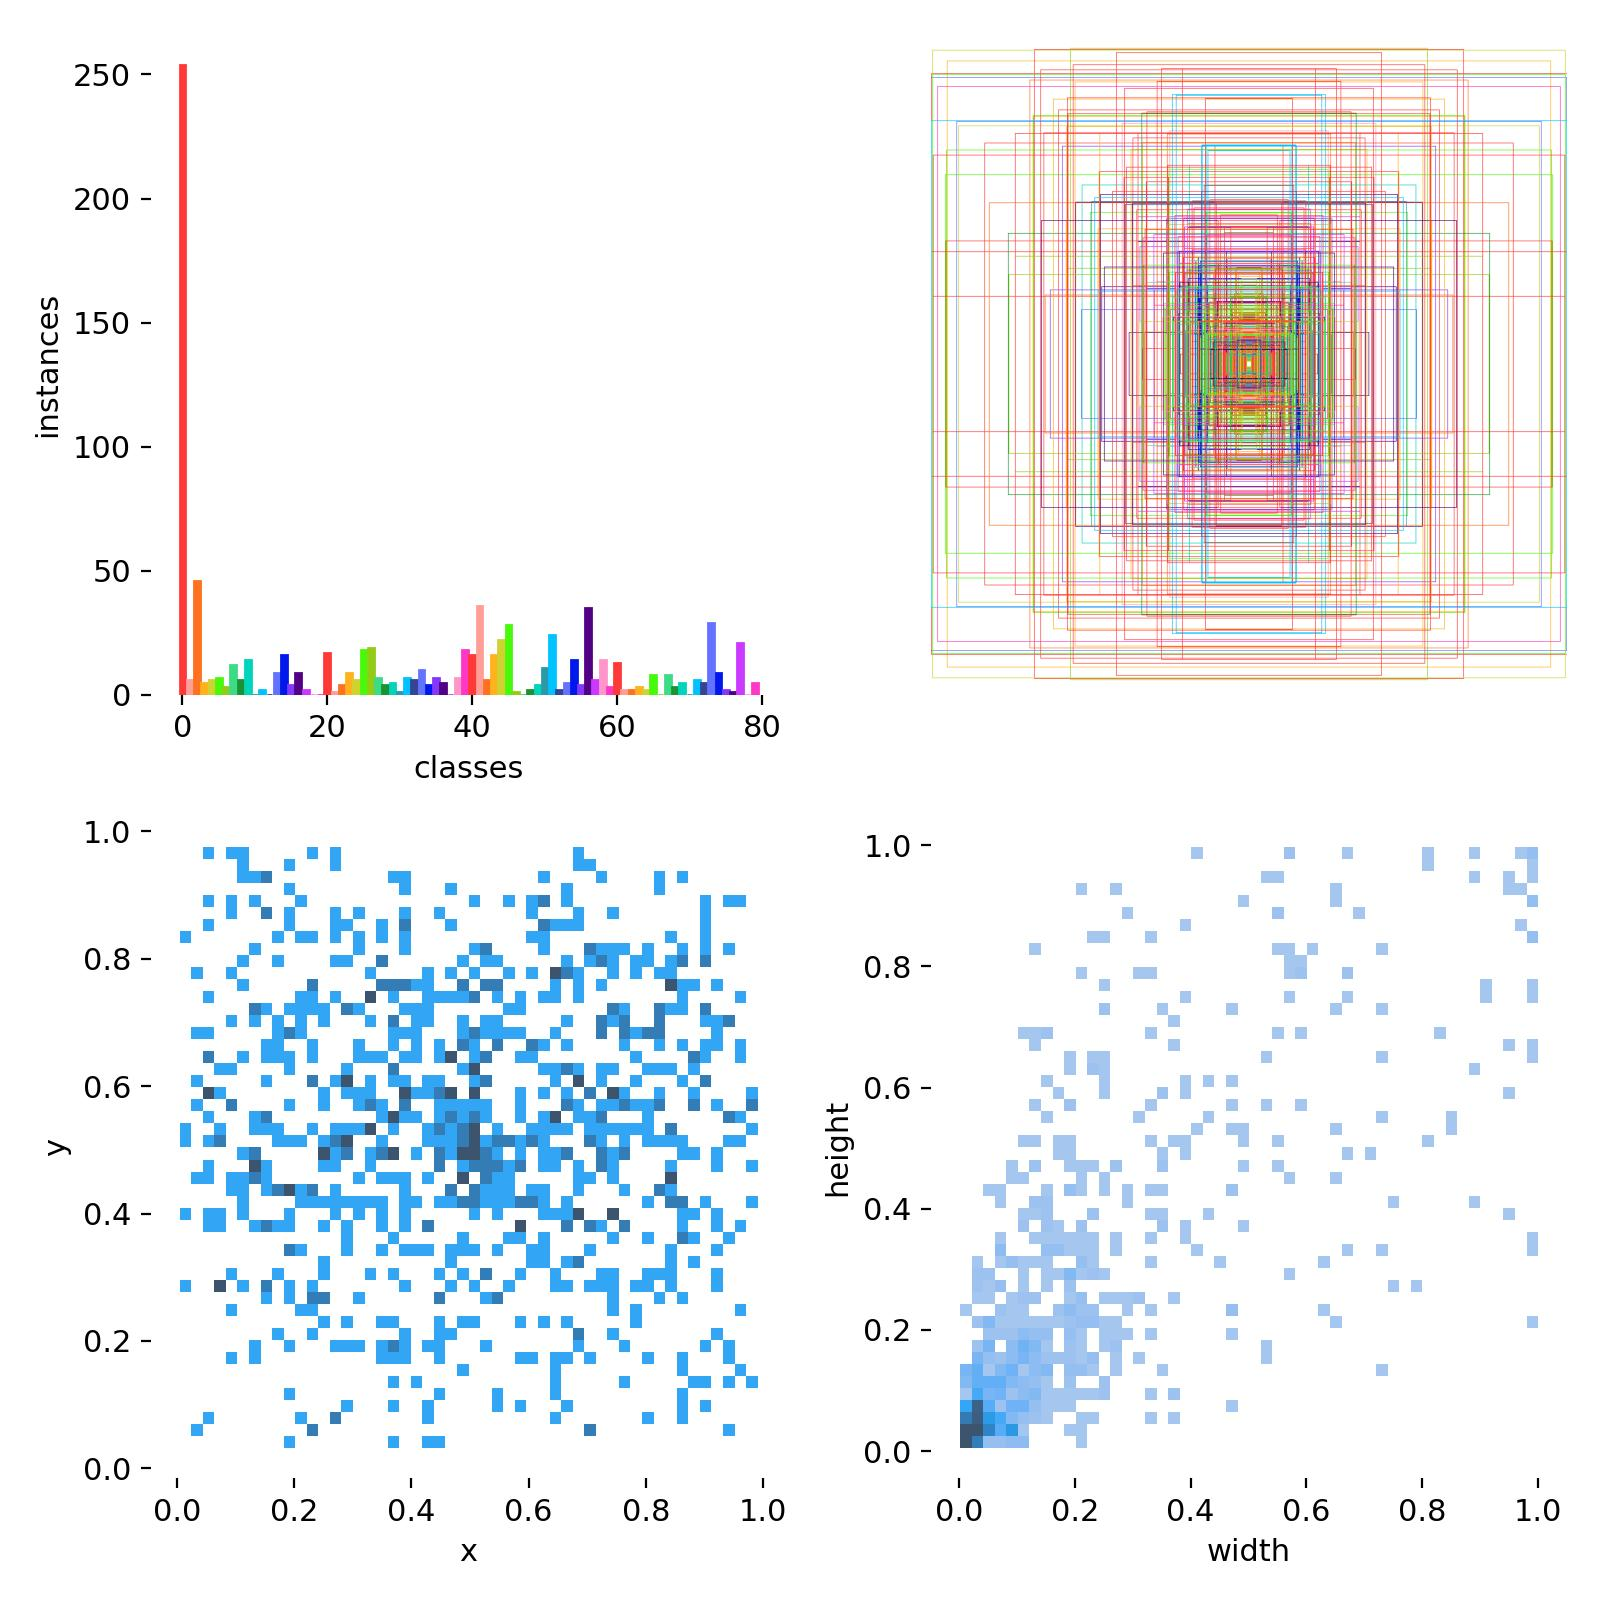

In [18]:
import IPython
IPython.display.Image('labels.jpg')

## Image segmentation

In [19]:
from ultralytics import YOLO
model = YOLO('yolov8x-seg.pt')

100%|████████████████████████████████████████| 137M/137M [00:07<00:00, 18.3MB/s]


In [20]:
model.predict(source=0, show=True)


1/1: 0... Success ✅ (inf frames of shape 1280x720 at 1.00 FPS)


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

0: 384x640 1 person, 1173.2ms
0: 384x640 1 person, 1096.7ms
0: 384x640 1 person, 1093.8ms
0: 384x640 1 person, 1258.2ms
0: 384x640 1 person, 1307.8ms
0: 384x640 1 person, 1321.0ms
0: 384x640 1 person, 1234.6ms
0: 384x640 1 person, 1243.1ms
0: 384x640 1 person, 1242.3ms
0: 384x640 1 person, 1190.6ms
0: 384x640 1 person, 1173.8ms
0: 384x640 1 person, 1188.8ms
0: 384x640 1 person, 1190.3ms
0:

KeyboardInterrupt: 

In [23]:
print(dir(model))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_check_is_pytorch_model', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_hub_session', '_get_name', '_is_full_backward_hook', '_load', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_new', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_r